In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

sys.path.append('..')
from genotype_evaluator import GenotypeEvaluator

%matplotlib inline

## NSGA-II implementation

In [2]:
def fast_non_dominated_sort(f1_values, f2_values):
    samples_count = f1_values.shape[0]
    dominant_count = {i: 0 for i in range(samples_count)}
    dominated_set = {i: set() for i in range(samples_count)}
    for i in range(samples_count):
        for j in range(i):
            if f1_values[i] == f1_values[j] and f2_values[i] == f2_values[j]:
                continue
            if f1_values[i] <= f1_values[j] and f2_values[i] <= f2_values[j]:
                dominant_count[j] += 1
                dominated_set[i].add(j)
            elif f1_values[i] >= f1_values[j] and f2_values[i] >= f2_values[j]:
                dominant_count[i] += 1
                dominated_set[j].add(i)
    dominant_batches = []
    while len(dominant_count) > 0:
        zero_indexes = list(filter(lambda x: dominant_count[x] == 0, dominant_count))
        dominant_batches.append(set(zero_indexes))
        for zero_index in zero_indexes:
            del dominant_count[zero_index]
            for dominated_index in dominated_set[zero_index]:
                dominant_count[dominated_index] -= 1            
    return dominant_batches
    
print(fast_non_dominated_sort(np.array([1, 2, 3]), np.array([6, 5, 4])))
print(fast_non_dominated_sort(np.array([1, 2, 3, 4, 5, 6, 7]), np.array([2, 1, 4, 3, 7, 6, 5])))

[{0, 1, 2}]
[{0, 1}, {2, 3}, {4, 5, 6}]


In [3]:
def get_crowding_distances(f1_values, f2_values):
    samples_count = f1_values.shape[0]
    crowding_distances = [0 for i in range(samples_count)]
    sorted_f1_args = np.argsort(f1_values)
    sorted_f2_args = np.argsort(f2_values)
    for i in range(1, samples_count - 1):
        prev_f1_arg, cur_f1_arg, next_f1_arg = sorted_f1_args[i - 1:i + 2] 
        prev_f2_arg, cur_f2_arg, next_f2_arg = sorted_f2_args[i - 1:i + 2]
        f1_dist = (f1_values[next_f1_arg] - f1_values[prev_f1_arg]) / (max(f1_values) - min(f1_values))
        f2_dist = (f2_values[next_f2_arg] - f2_values[prev_f2_arg]) / (max(f2_values) - min(f2_values))
        crowding_distances[cur_f1_arg] += f1_dist
        crowding_distances[cur_f2_arg] += f2_dist
    crowding_distances[sorted_f1_args[0]] = np.inf
    crowding_distances[sorted_f1_args[samples_count - 1]] = np.inf
    crowding_distances[sorted_f2_args[0]] = np.inf    
    crowding_distances[sorted_f2_args[samples_count - 1]] = np.inf        
    return np.array(crowding_distances)
    
print(get_crowding_distances(np.array([1, 2, 5, 3, 10, 3, 20]), np.array([10, 15, 7, 11, 1, 20, 21])))

[       inf 0.55526316 0.81842105 0.30263158        inf 0.40526316
        inf]


In [4]:
def crossover(parent1, parent2, crossover_prob):
    if np.random.rand() <= crossover_prob:
        gen_intersection_point = np.random.choice(parent1.shape[0])
        child1 = np.hstack([parent1[:gen_intersection_point], parent2[gen_intersection_point:]])
        child2 = np.hstack([parent2[:gen_intersection_point], parent1[gen_intersection_point:]])
        return child1, child2
    return parent1.copy(), parent2.copy()


def mutate_randomly(sample, mutation_prob):
    for i in range(sample.shape[0]):
        if np.random.rand() <= mutation_prob:
            sample[i] = np.random.choice(3)

            
def make_new_population(samples, crossover_prob, mutation_prob):
    children = []
    for i in range(0, samples.shape[0], 2):
        child1, child2 = crossover(samples[i], samples[i + 1], crossover_prob)
        mutate_randomly(child1, mutation_prob)
        mutate_randomly(child2, mutation_prob)
        children.extend([child1, child2])
    return np.array(children)


print(crossover(np.array([0, 1, 1, 2]), np.array([2, 1, 0, 1]), 0.75))
x = np.array([0, 0, 1, 2, 1, 1, 0])
mutate_randomly(x, 0.2)
print(x)
print(make_new_population(np.array([[0, 0, 1, 2], [2, 2, 2, 1]]), 0.8, 0.2))

(array([2, 1, 0, 1]), array([0, 1, 1, 2]))
[0 0 1 2 1 1 0]
[[0 1 1 1]
 [2 2 1 2]]


In [8]:
def nsga2(objective_function, population_size, chromosom_length, crossover_prob, mutation_prob, max_time):
    populations = []
    population = np.random.choice(3, (population_size, chromosom_length))
    start_time = time.time()    
    while time.time() - start_time < max_time:
        selected_samples = []
        f1_values, f2_values = objective_function(population)
        dominant_batches = fast_non_dominated_sort(f1_values, f2_values)
        print("Obj1 mean/max: %d/%d, obj2 mean/max: %d/%d, dominant batches count/first size: %d/%d" 
            % (-np.mean(f1_values), -np.min(f1_values), -np.mean(f2_values), -np.min(f2_values), 
                len(dominant_batches), len(dominant_batches[0]))
        )          
        batch_number = 0
        while batch_number < len(dominant_batches) and len(selected_samples) + len(dominant_batches[batch_number]) <= population_size:
            selected_samples.extend(population[list(dominant_batches[batch_number])])
            batch_number += 1
        if population_size - len(selected_samples) > 0:
            batch_indexes = np.array(list(dominant_batches[batch_number]), dtype=np.int32)  
            crowding_distances = get_crowding_distances(f1_values[batch_indexes], f2_values[batch_indexes])
            sliced_indexes = list(reversed(np.argsort(crowding_distances)))
            crowding_indexes = np.array(sliced_indexes, dtype=np.int32)[:(population_size - len(selected_samples))]
            selected_samples.extend(population[batch_indexes[crowding_indexes]])  
        children = make_new_population(np.array(selected_samples), crossover_prob, mutation_prob)
        population = np.unique(np.vstack([selected_samples, children]), axis=0)
        populations.append(population)
    dominant_batches = fast_non_dominated_sort(*objective_function(population))
    return populations

## Rounded board evaluator

In [6]:
genotype_evaluator = GenotypeEvaluator('../clusters/human100_cluster.c', ['../boards/round_board.b'], True)

def evaluate_min_genotypes(genotypes):
    f1_values, f2_values = genotype_evaluator.evaluate_genotypes(genotypes)
    return -f1_values, -f2_values

In [10]:
populations = nsga2(evaluate_min_genotypes, 100, 100, 0.9, 0.05, 3600)

Obj1 mean/max: 321/667, obj2 mean/max: 33/45, dominant batches count/first size: 22/3
Obj1 mean/max: 317/685, obj2 mean/max: 33/47, dominant batches count/first size: 36/5
Obj1 mean/max: 415/685, obj2 mean/max: 35/47, dominant batches count/first size: 26/7
Obj1 mean/max: 459/885, obj2 mean/max: 37/47, dominant batches count/first size: 25/6
Obj1 mean/max: 502/885, obj2 mean/max: 38/51, dominant batches count/first size: 24/7
Obj1 mean/max: 527/1138, obj2 mean/max: 38/54, dominant batches count/first size: 24/6
Obj1 mean/max: 536/1138, obj2 mean/max: 39/54, dominant batches count/first size: 19/4
Obj1 mean/max: 551/1138, obj2 mean/max: 39/54, dominant batches count/first size: 24/5
Obj1 mean/max: 562/2110, obj2 mean/max: 40/55, dominant batches count/first size: 21/7
Obj1 mean/max: 567/2110, obj2 mean/max: 42/57, dominant batches count/first size: 24/6
Obj1 mean/max: 582/2110, obj2 mean/max: 43/57, dominant batches count/first size: 25/7
Obj1 mean/max: 584/2110, obj2 mean/max: 44/57, d

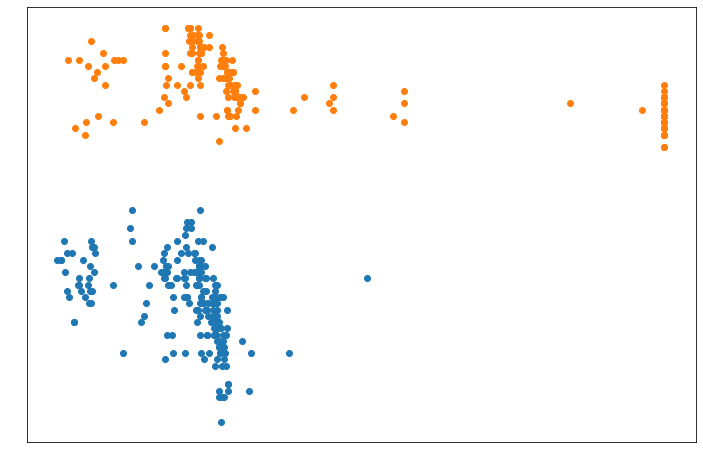

In [18]:
gen5_f1_values, gen5_f2_values = genotype_evaluator.evaluate_genotypes(populations[5])
last_gen_f1_values, last_gen_f2_values = genotype_evaluator.evaluate_genotypes(populations[-1])
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
ax.scatter(gen5_f1_values, gen5_f2_values)
ax.scatter(last_gen_f1_values, last_gen_f2_values)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

In [43]:
gen5_genotype = populations[5][np.argmax(f1_values)]
last_gen_priorities = list(zip(last_gen_f1_values, last_gen_f2_values))
best_index = sorted(range(len(populations[-1])), key=lambda x: last_gen_priorities[x])[-1] 
best_genotype = populations[-1][best_index]

In [45]:
with open('../individuals/rb_nsga2_gen5.i', 'wb') as file_stream:
    gen5_individual = genotype_evaluator.individual_factory.create_individual(gen5_genotype)
    gen5_individual.marker_manager.game_state_marker_lines = {}
    pickle.dump(gen5_individual, file_stream)
with open('../individuals/rb_nsga2_best.i', 'wb') as file_stream:
    best_individual = genotype_evaluator.individual_factory.create_individual(best_genotype)
    best_individual.marker_manager.game_state_marker_lines = {}
    pickle.dump(best_individual, file_stream)